In [139]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix,matthews_corrcoef,make_scorer,precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold,learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector as selector
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder


from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import balanced_accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier
import time

import time
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import cross_validate
from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import StratifiedKFold

In [140]:
df_ep_model = pd.read_csv('clean_data.csv')

In [141]:
df_ep_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10572 entries, 0 to 10571
Columns: 183 entries, fpLILEEflg to fpLIHCflg
dtypes: float64(19), int64(164)
memory usage: 14.8 MB


In [142]:
df_ep_model.columns

Index(['fpLILEEflg', 'AHCIncomeEQ_LILEE', 'fpfullinc', 'fuelexpn',
       'FuelCosteqFactor', 'EqAHCincDeciles_LILEE', 'elecmop', 'gasmop',
       'aagph2021_x', 'FPGAP_LILEE',
       ...
       'sap12', 'sap412', 'rdsap09', 'EPceeb12e', 'EPceir12e', 'EPceib12e',
       'Equivalised fuel costs', 'Equivalised AHC income',
       'household_income_threshold', 'fpLIHCflg'],
      dtype='object', length=183)

# Combinations of Inputs

In [143]:
# select variables for the model
list_census_proxy = ['hhsizex','sft','nssech9','nssecp9','hhtype11','ager'
,'sexhrp','hhcomp1','ndepchild','hhltsick','tenure2','prevten','tenex','tenure4x'
,'bedrqx','DWtype','fuelx'] # DWtype (8 category) and heating fuel type is also in the census criteria
list_other_inputs_proxy = ['HYEARGRx','FloorArea','housex'] 

list_NEED_proxy = ['sap12']  

# Combination 1: Census only as inputs
# Combination 2: Census + other inputs

# the combination 3 is an addtional combination that includes the enegy efficiency rating as Supplemental material
# Combination 3: Census + other inputs + NEED

# get entire tidy dataset
df_ep_model = df_ep_model[list_census_proxy + list_other_inputs_proxy + list_NEED_proxy + ['fpLIHCflg']]
df_ep_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10572 entries, 0 to 10571
Data columns (total 22 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   hhsizex    10572 non-null  int64  
 1   sft        10572 non-null  int64  
 2   nssech9    10572 non-null  int64  
 3   nssecp9    10572 non-null  int64  
 4   hhtype11   10572 non-null  int64  
 5   ager       10572 non-null  int64  
 6   sexhrp     10572 non-null  int64  
 7   hhcomp1    10572 non-null  int64  
 8   ndepchild  10572 non-null  int64  
 9   hhltsick   10572 non-null  int64  
 10  tenure2    10572 non-null  int64  
 11  prevten    10572 non-null  int64  
 12  tenex      10572 non-null  int64  
 13  tenure4x   10572 non-null  int64  
 14  bedrqx     10572 non-null  int64  
 15  DWtype     10572 non-null  int64  
 16  fuelx      10572 non-null  int64  
 17  HYEARGRx   10572 non-null  float64
 18  FloorArea  10572 non-null  int64  
 19  housex     10572 non-null  int64  
 20  sap12 

# Data split

In [144]:
# copy dataframe (entire tidy dataset is all inputs + target data for data split in train set and test set, test set will be used for final evaluation)
X = df_ep_model.drop(columns=['fpLIHCflg']).copy()
y = df_ep_model['fpLIHCflg'].copy()

# data split
Train_x, Test_x, Train_y, Test_y = train_test_split(X, y, stratify=y, random_state=42)
Train_x.shape, Test_x.shape, Train_y.shape, Test_y.shape

# we separate the test set and only use it for the final evaluation

((7929, 21), (2643, 21), (7929,), (2643,))

In [145]:
Train_x

,hhsizex,sft,nssech9,nssecp9,hhtype11,ager,sexhrp,hhcomp1,ndepchild,hhltsick,...,prevten,tenex,tenure4x,bedrqx,DWtype,fuelx,HYEARGRx,FloorArea,housex,sap12
3579,2,0,6,0,9,6,2,5,0,1,...,9,2,1,2,4,1,22435.0,1,1,61.81
8506,3,2,2,7,4,4,2,1,0,1,...,9,1,1,2,2,1,71875.0,2,1,69.84
54,4,2,5,1,2,3,1,1,2,2,...,9,1,1,3,3,1,100000.0,5,1,64.89
6257,5,1,6,6,3,4,1,1,2,2,...,9,3,2,3,3,1,29347.8,4,1,62.04
6669,5,0,-9,0,5,2,2,3,4,2,...,6,5,4,3,2,1,14398.8,3,1,73.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2932,3,2,2,1,2,4,1,1,1,2,...,3,1,1,2,4,4,100000.0,5,1,64.97
5188,2,0,2,3,1,6,1,1,0,2,...,9,2,1,1,4,1,45090.0,5,1,68.83
2798,2,1,7,0,9,6,1,4,0,1,...,9,5,4,2,1,1,13835.0,5,1,72.31
2703,2,2,1,1,1,4,2,1,0,2,...,9,1,1,1,4,1,100000.0,5,1,52.80


# Functions

## Model section and handling imbalance data in classification

In [146]:
# Define a fixed Stratified K-Fold object (to make sure that the same folds are used for both model selection and hyperparameter tuning)
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [147]:
def select_models(X, y):
    """
    Evaluates different machine learning models using cross-validation and returns a DataFrame of scores.
    
    Parameters:
    - X: pd.DataFrame - Features
    - y: pd.Series - Target labels
    
    Returns:
    - df_scores: pd.DataFrame - Model performance scores (Accuracy & Balanced Accuracy)

    * Uses default k-fold cross-validation with k=5
    """
    start = time.time()  # Start timing

    # Define metrics for evaluation
    scoring = ["accuracy", "balanced_accuracy"]

    # Preprocessor for Random Forest (OHE for categorical, Scaling applied but ignored)
    num_pipe_rf = make_pipeline(
        SimpleImputer(strategy="mean", add_indicator=True),  # Fill missing values
        StandardScaler()  # Applied but RF ignores it
    )
    
    cat_pipe_rf = make_pipeline(
        SimpleImputer(strategy="constant", fill_value="missing"),  # Fill missing categorical values
        OneHotEncoder(handle_unknown="ignore")  # One-hot encoding for RF
    )

    preprocessor_rf = make_column_transformer(
        (num_pipe_rf, selector(dtype_include="number")),  
        (cat_pipe_rf, selector(dtype_include="category")),  
        n_jobs=-1
    )

    # Preprocessor for XGBoost (OHE for categorical, Scaling applied and used)
    num_pipe_xgb = make_pipeline(
        SimpleImputer(strategy="mean", add_indicator=True),  # Fill missing values
        StandardScaler()  # Scaling is beneficial for XGBoost
    )

    cat_pipe_xgb = make_pipeline(
        SimpleImputer(strategy="constant", fill_value="missing"),  
        OneHotEncoder(handle_unknown="ignore")  # One-hot encoding for XGBoost
    )

    preprocessor_xgb = make_column_transformer(
        (num_pipe_xgb, selector(dtype_include="number")),  
        (cat_pipe_xgb, selector(dtype_include="category")),  
        n_jobs=-1
    )

    # Initialize results storage
    index = []
    scores = {"Accuracy": [], "Balanced accuracy": []}

    # Dummy classifier (baseline)
    dummy_clf = DummyClassifier(strategy="most_frequent")
    index.append("Dummy classifier")
    cv_result = cross_validate(dummy_clf, X, y, scoring=scoring, cv=cv_folds)
    scores["Accuracy"].append(cv_result["test_accuracy"].mean())
    scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

    # RF + undersampling (Uses `preprocessor_rf`)
    rf_clf = make_pipeline_with_sampler(
        preprocessor_rf,
        RandomUnderSampler(random_state=42),
        RandomForestClassifier(random_state=42, n_jobs=-1)
    )
    index.append("Random forest with undersampling")
    cv_result = cross_validate(rf_clf, X, y, scoring=scoring, cv=cv_folds)
    scores["Accuracy"].append(cv_result["test_accuracy"].mean())
    scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

    # RF + balanced class weights (Uses `preprocessor_rf`)
    rf_clf.set_params(randomforestclassifier__class_weight="balanced")
    index.append("Random forest with balanced class weights")
    cv_result = cross_validate(rf_clf, X, y, scoring=scoring,cv=cv_folds)
    scores["Accuracy"].append(cv_result["test_accuracy"].mean())
    scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

    # XGBoost + undersampling (Uses `preprocessor_xgb`)
    xgb_clf = make_pipeline_with_sampler(
        preprocessor_xgb,
        RandomUnderSampler(random_state=42),
        XGBClassifier(random_state=42, n_jobs=-1)
    )
    index.append("XGBoost with undersampling")
    cv_result = cross_validate(xgb_clf, X, y, scoring=scoring, cv=cv_folds)
    scores["Accuracy"].append(cv_result["test_accuracy"].mean())
    scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

    # XGBoost + class balancing (scale_pos_weight) (Uses `preprocessor_xgb`)
    num_neg = (y == 0).sum()  
    num_pos = (y == 1).sum()  
    scale_pos_weight = num_neg / num_pos  

    xgb_clf = make_pipeline(
        preprocessor_xgb,
        XGBClassifier(
            scale_pos_weight=scale_pos_weight,
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            random_state=42,
            n_jobs=-1
        )
    )
    index.append("XGBoost with scale_pos_weight")
    cv_result = cross_validate(xgb_clf, X, y, scoring=scoring, cv=cv_folds)
    scores["Accuracy"].append(cv_result["test_accuracy"].mean())
    scores["Balanced accuracy"].append(cv_result["test_balanced_accuracy"].mean())

    # Store results in DataFrame
    df_scores = pd.DataFrame(scores, index=index)

    # Remove dummy classifier from final results
    df_scores.drop('Dummy classifier', inplace=True)

    # Finish timing
    end = time.time()
    print(f"Time elapsed: {end - start:.2f} s")

    return df_scores, xgb_clf, preprocessor_xgb, scale_pos_weight


## Optimized function for xgb model hyperparameter tuning

function to train and tune XGBoost with scale_pos_weight using RandomizedSearchCV

In [148]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from xgboost import XGBClassifier

def tune_xgboost(selected_model, preprocessor_xgb, scale_pos_weight, X_train, y_train, n_iter=30):
    """
    Tunes hyperparameters for the selected XGBoost model with preprocessing inside a pipeline.

    Parameters:
    - selected_model: The model chosen from model selection (Pipeline with XGBoost)
    - preprocessor_xgb: The preprocessor for XGBoost (ColumnTransformer)
    - scale_pos_weight: The computed class imbalance ratio from model selection
    - X_train: Training features
    - y_train: Training labels
    - n_iter: Number of hyperparameter combinations to test (default=30)

    Returns:
    - best_model: The best hyperparameter-tuned XGBoost model (Pipeline)
    - best_params: Best hyperparameters found
    """

    print("Hyperparameter tuning with RandomizedSearchCV")

    # Extract preprocessing step from the selected pipeline
    preprocessor = preprocessor_xgb # Ensure this matches pipeline step name

    # Rebuild the model with scale_pos_weight fixed
    xgb_tune = XGBClassifier(
        scale_pos_weight=scale_pos_weight,  # Ensure it is retained!
        random_state=42,
        n_jobs=-1
    )

    # Define full pipeline (preprocessing + model)
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Include preprocessing step
        ('xgb', xgb_tune)  # XGBoost model
    ])

    # Define hyperparameter search space (corrected with "xgb__" prefix)
    param_dist = {
        'xgb__n_estimators': randint(100, 500),
        'xgb__learning_rate': uniform(0.01, 0.3),
        'xgb__max_depth': randint(3, 12),
        'xgb__subsample': uniform(0.5, 0.5),
        'xgb__colsample_bytree': uniform(0.5, 0.5),
        'xgb__gamma': uniform(0, 5),
        'xgb__reg_lambda': uniform(0, 10),
        'xgb__reg_alpha': uniform(0, 10)
    }

    # Setup RandomizedSearchCV (using the same CV folds as model selection)
    random_search = RandomizedSearchCV(
        estimator=pipeline,  # Tune the entire pipeline (preprocessor + XGBoost)
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=cv_folds,  # Ensure same cross-validation folds as model selection
        scoring='balanced_accuracy',
        n_jobs=-1,
        random_state=42
    )

    # Fit RandomizedSearchCV
    random_search.fit(X_train, y_train)

    # Extract best pipeline (preprocessing + tuned XGB)
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    best_score = random_search.best_score_

    # Print results
    print("\nHyperparameter Tuning Complete")
    print("Best Hyperparameters:", best_params)
    print(f"Best Balanced Accuracy: {best_score:.4f}")

    return best_model, best_params


## Set custom threshold for confusion matrix

In [149]:
def tune_classification_threshold(best_model, X_test, y_test, set_threshold=0.5, risk_label=1):
    """
    Tunes classification threshold and evaluates model performance.

    Parameters:
    - best_model: Trained classifier with `predict_proba()`
    - X_test: pd.DataFrame - Test set features
    - y_test: pd.Series - True labels for test set
    - set_threshold: float - The threshold to use for final evaluation (default=0.5)
    - risk_label: int - The class label for "at risk" classification (default=1)

    Returns:
    - best_threshold: float - Optimal threshold for highest F1 score
    - metrics_at_custom_threshold: dict - Evaluation metrics at custom threshold
    """

    print("Tuning classification threshold")

    # Get probabilities for each class
    probs = best_model.predict_proba(X_test)

    # Define threshold values
    thresholds = np.linspace(0, 1, 101)  # Generate 101 thresholds from 0 to 1

    # Initialize lists to store metrics
    f1_scores = []
    precisions = []
    recalls = []
    specificities = []
    accuracies = []

    # Loop through each threshold and compute metrics
    for threshold in thresholds:
        preds = (probs[:, risk_label] >= threshold).astype(int)
        
        # Compute confusion matrix components
        tn, fp, fn, tp = confusion_matrix(y_test == risk_label, preds).ravel()
        
        # Compute metrics safely (avoid division by zero)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = accuracy_score(y_test == risk_label, preds)

        # Store results
        f1_scores.append(f1)
        precisions.append(precision)
        recalls.append(recall)
        specificities.append(specificity)
        accuracies.append(accuracy)

    # Find the best threshold (based on F1-score)
    best_f1 = max(f1_scores)
    best_threshold = thresholds[f1_scores.index(best_f1)]
    print(f"\n🔹 Best threshold for highest F1-score: {best_threshold:.2f}")

    # Define the custom threshold
    custom_threshold = set_threshold

    # Evaluate model at the custom threshold
    best_preds = (probs[:, risk_label] >= custom_threshold).astype(int)
    cm = confusion_matrix(y_test == risk_label, best_preds)

    # Plot all metrics against threshold
    plt.figure(figsize=(10, 8))
    plt.plot(thresholds, f1_scores, label="F1 Score", marker='.')
    plt.plot(thresholds, precisions, label="Precision", marker='.')
    plt.plot(thresholds, recalls, label="Recall", marker='.')
    plt.plot(thresholds, specificities, label="Specificity", marker='.')
    plt.plot(thresholds, accuracies, label="Accuracy", marker='.')
    plt.axvline(custom_threshold, color='black', linestyle='--', label=f"Custom Threshold ({custom_threshold:.2f})")
    # plt.axvline(best_threshold, color='g', linestyle='--', label=f"Best F1 Threshold ({best_threshold:.2f})")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Model Metrics vs. Threshold")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Classification report at the selected custom threshold
    print(f"\n🔹 Classification report at custom threshold ({custom_threshold:.2f}):")
    print(classification_report(y_test == risk_label, best_preds, target_names=['Not at risk', 'At risk']))
    
    # Compute balanced accuracy
    bal_acc = balanced_accuracy_score(y_test == risk_label, best_preds)
    print(f"🔹 Balanced Accuracy at threshold {custom_threshold:.2f}: {bal_acc:.4f}")

    # Store results in a dictionary
    metrics_at_custom_threshold = {
        "Custom Threshold": custom_threshold,
        "Best F1 Threshold": best_threshold,
        "Balanced Accuracy": bal_acc,
        "F1 Score": f1_scores[thresholds.tolist().index(custom_threshold)],
        "Precision": precisions[thresholds.tolist().index(custom_threshold)],
        "Recall": recalls[thresholds.tolist().index(custom_threshold)],
        "Specificity": specificities[thresholds.tolist().index(custom_threshold)],
        "Accuracy": accuracies[thresholds.tolist().index(custom_threshold)],
        "Confusion Matrix": cm
    }

    return best_threshold, metrics_at_custom_threshold


# COM-1 : Census only model

In [150]:
# select inputs and target variable for COM-1, use only train set for model selection
df_res = Train_x[list_census_proxy].copy()
y_res = Train_y.copy()

# compare model selection results, get the best selected model (xgb), sgb_preprocessor and scale_pos_weight
df_scores, select_model,preprocessor_xgb,scale_pos_weight = select_models(df_res, y_res)
df_scores

Time elapsed: 15.07 s


,Accuracy,Balanced accuracy
Random forest with undersampling,0.778283,0.783056
Random forest with balanced class weights,0.778283,0.783056
XGBoost with undersampling,0.779796,0.780391
XGBoost with scale_pos_weight,0.828605,0.783107


## XGBoost Model training, tunning parameters, evaluation

In [151]:
# copy data, make sure that train set is the same to data used for model selection, and test set is the one we separated at the beginning
X_train = df_res.copy()
y_train = y_res.copy()

X_test = Test_x[list_census_proxy].copy()
y_test = Test_y.copy()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7929, 17), (2643, 17), (7929,), (2643,))

In [152]:
# Train the model by X_train and y_train, and optimize XGBoost model by tunning hyperparameters, get the best model
best_model, best_params = tune_xgboost(select_model,preprocessor_xgb, scale_pos_weight, X_train, y_train,)

# Best model performance
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))

Hyperparameter tuning with RandomizedSearchCV

Hyperparameter Tuning Complete
Best Hyperparameters: {'xgb__colsample_bytree': 0.6933676731502687, 'xgb__gamma': 4.6836499436836725, 'xgb__learning_rate': 0.051256283243797975, 'xgb__max_depth': 11, 'xgb__n_estimators': 250, 'xgb__reg_alpha': 5.414479738275658, 'xgb__reg_lambda': 6.957843993450822, 'xgb__subsample': 0.6142750108986499}
Best Balanced Accuracy: 0.8084
              precision    recall  f1-score   support

           0       0.96      0.80      0.87      2285
           1       0.37      0.77      0.50       358

    accuracy                           0.79      2643
   macro avg       0.67      0.78      0.69      2643
weighted avg       0.88      0.79      0.82      2643

Balanced Accuracy: 0.7843807684314756


Tuning classification threshold

🔹 Best threshold for highest F1-score: 0.74


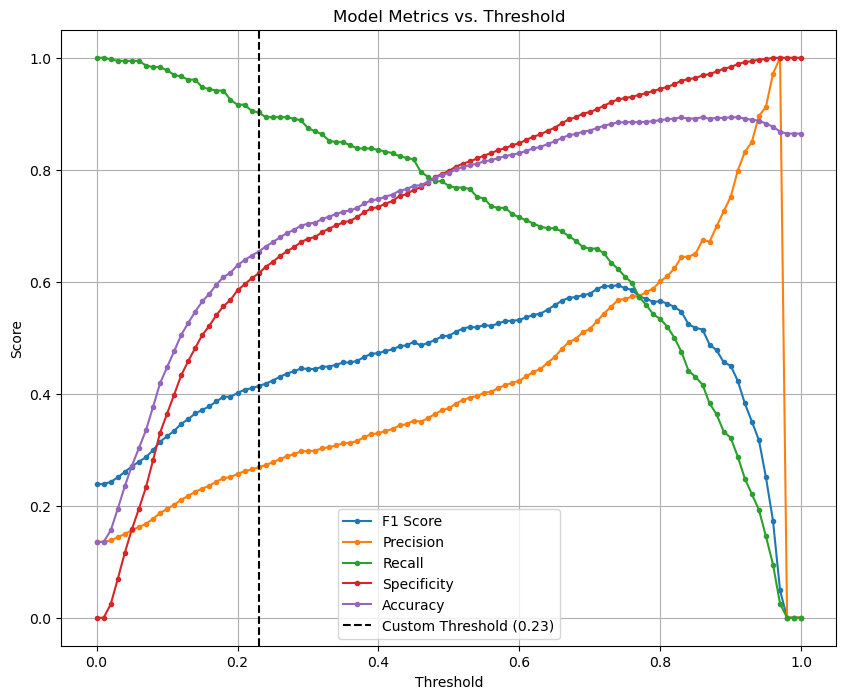


🔹 Classification report at custom threshold (0.23):
              precision    recall  f1-score   support

 Not at risk       0.98      0.61      0.75      2285
     At risk       0.27      0.90      0.41       358

    accuracy                           0.65      2643
   macro avg       0.62      0.76      0.58      2643
weighted avg       0.88      0.65      0.71      2643

🔹 Balanced Accuracy at threshold 0.23: 0.7586


In [157]:
# Custom setting threshold and get the best threshold for highest Recall
best_threshold, metrics_at_custom_threshold = tune_classification_threshold(best_model, X_test, y_test, set_threshold=0.23)


ROC AUC: 0.88


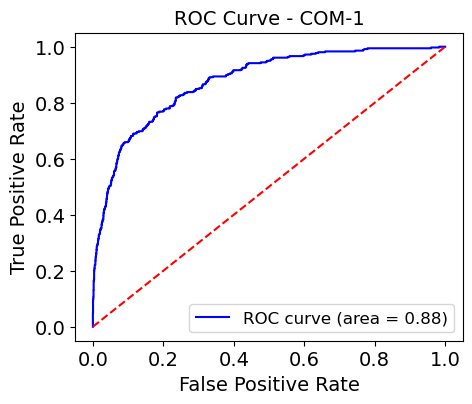

In [158]:
# Calculate ROC AUC score
#  "at risk" is class 1
double_risk_label = 1
# Get probabilities for each class
probs = best_model.predict_proba(X_test)

roc_auc = roc_auc_score(y_test, probs[:, double_risk_label])
print(f"ROC AUC: {roc_auc:.2f}")

# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test, probs[:, double_risk_label])

# Plot ROC curve
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')

# Adjust font sizes
plt.xlabel("False Positive Rate", fontsize=14)  
plt.ylabel("True Positive Rate", fontsize=14)  
plt.title("ROC Curve - COM-1", fontsize=14)  
plt.legend(fontsize=12)  
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.savefig('./plots_of_results/roc_curve_com_1.png', dpi=300, bbox_inches='tight')
plt.show()

# COM-2 : Census + other inputs

In [159]:
# select inputs and target variable for COM-2, use only train set for model selection
df_res = Train_x[list_census_proxy + list_other_inputs_proxy].copy()
y_res = Train_y.copy()

# compare model selection results, get the best selected model (xgb), sgb_preprocessor and scale_pos_weight
df_scores, select_model,preprocessor_xgb,scale_pos_weight = select_models(df_res, y_res)
df_scores

Time elapsed: 2.41 s


,Accuracy,Balanced accuracy
Random forest with undersampling,0.861900,0.871861
Random forest with balanced class weights,0.861900,0.871861
XGBoost with undersampling,0.865935,0.871055
XGBoost with scale_pos_weight,0.897717,0.872551


## XGBoost Model training, tunning parameters, evaluation

In [160]:
# copy data, make sure that train set is the same to data used for model selection, and test set is the one we separated at the beginning
X_train = df_res.copy()
y_train = y_res.copy()

X_test = Test_x[list_census_proxy + list_other_inputs_proxy].copy()
y_test = Test_y.copy()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7929, 20), (2643, 20), (7929,), (2643,))

In [161]:
# Train the model by X_train and y_train, and optimize XGBoost model by tunning hyperparameters, get the best model
best_model, best_params = tune_xgboost(select_model,preprocessor_xgb, scale_pos_weight, X_train, y_train,)

# Best model performance
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))

Hyperparameter tuning with RandomizedSearchCV

Hyperparameter Tuning Complete
Best Hyperparameters: {'xgb__colsample_bytree': 0.6933676731502687, 'xgb__gamma': 4.6836499436836725, 'xgb__learning_rate': 0.051256283243797975, 'xgb__max_depth': 11, 'xgb__n_estimators': 250, 'xgb__reg_alpha': 5.414479738275658, 'xgb__reg_lambda': 6.957843993450822, 'xgb__subsample': 0.6142750108986499}
Best Balanced Accuracy: 0.8887
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      2285
           1       0.52      0.89      0.66       358

    accuracy                           0.88      2643
   macro avg       0.75      0.88      0.79      2643
weighted avg       0.92      0.88      0.89      2643

Balanced Accuracy: 0.8794989181325867


Tuning classification threshold

🔹 Best threshold for highest F1-score: 0.75


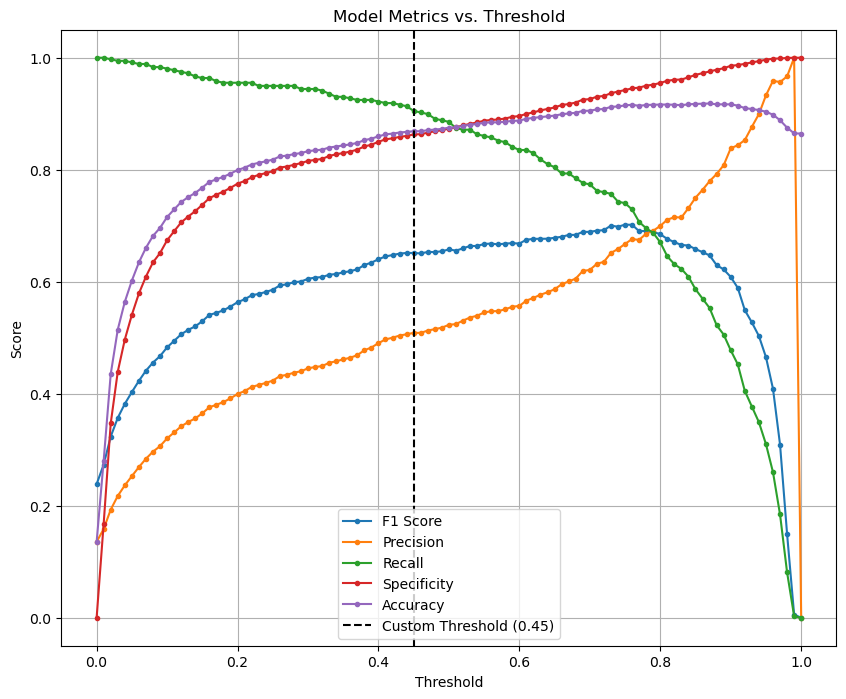


🔹 Classification report at custom threshold (0.45):
              precision    recall  f1-score   support

 Not at risk       0.98      0.86      0.92      2285
     At risk       0.51      0.91      0.65       358

    accuracy                           0.87      2643
   macro avg       0.75      0.88      0.79      2643
weighted avg       0.92      0.87      0.88      2643

🔹 Balanced Accuracy at threshold 0.45: 0.8840


In [172]:
# Custom setting threshold and get the best threshold for highest Recall
best_threshold, metrics_at_custom_threshold = tune_classification_threshold(best_model, X_test, y_test, set_threshold=0.45)


ROC AUC: 0.95


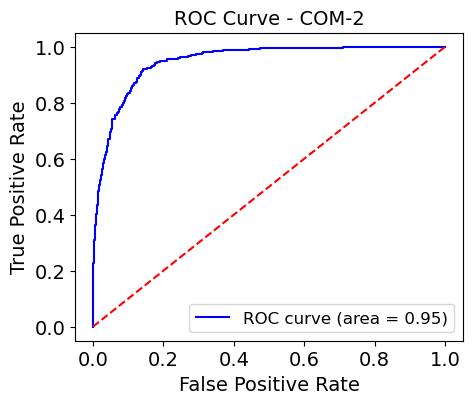

In [175]:
# Calculate ROC AUC score

#  "at risk" is class 1
double_risk_label = 1
# Get probabilities for each class
probs = best_model.predict_proba(X_test)

roc_auc = roc_auc_score(y_test, probs[:, double_risk_label])
print(f"ROC AUC: {roc_auc:.2f}")

# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test, probs[:, double_risk_label])

# Plot ROC curve
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')

# Adjust font sizes
plt.xlabel("False Positive Rate", fontsize=14)  
plt.ylabel("True Positive Rate", fontsize=14)  
plt.title("ROC Curve - COM-2", fontsize=14)  
plt.legend(fontsize=12)  
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.savefig('./plots_of_results/roc_curve_com_2.png', dpi=300, bbox_inches='tight')
plt.show()

# SHAP value of COM-2 model

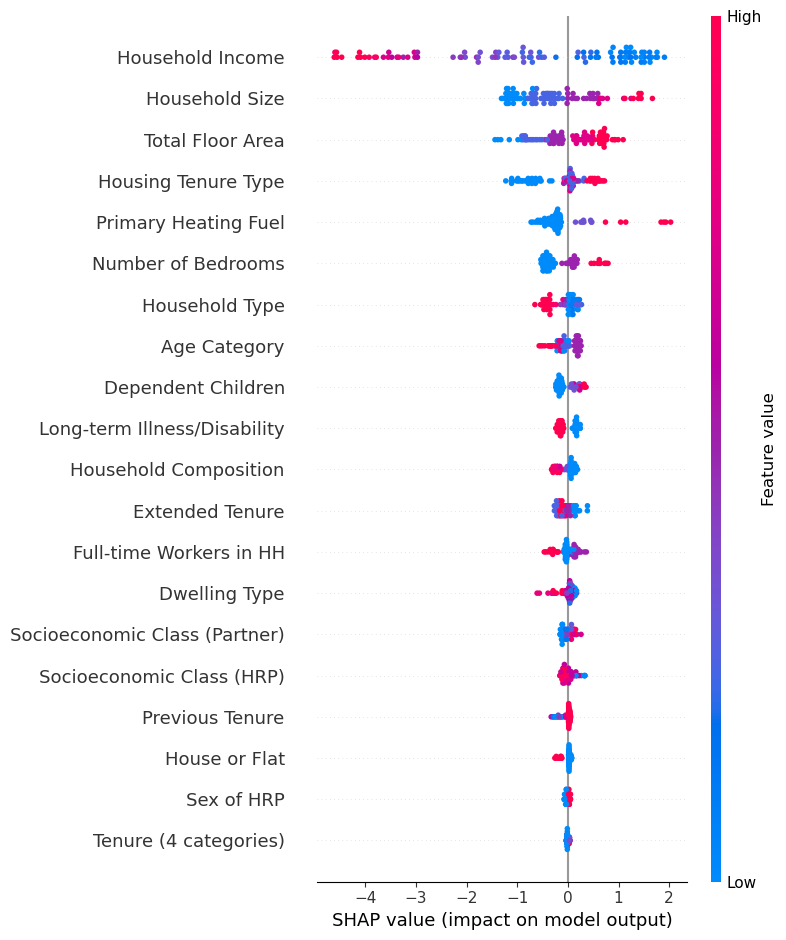

<Figure size 640x480 with 0 Axes>

In [176]:
import shap

# Extract the trained XGBoost model
xgb_model_2 = best_model.named_steps['xgb']

# Initialize SHAP explainer (TreeExplainer is best for XGBoost)
explainer = shap.TreeExplainer(xgb_model_2)

# Ensure the test data is preprocessed before passing to SHAP
X_sample_array = best_model.named_steps['preprocessor'].transform(X_test.iloc[:100])

# Retrieve transformed feature names from the preprocessor
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Convert the transformed array back into a DataFrame with correct feature names
X_sample = pd.DataFrame(X_sample_array, columns=feature_names)

# Define feature name mapping for readability (includes OneHotEncoded categorical features)
feature_names_map = {
    "pipeline-1__HYEARGRx": "Household Income",
    "pipeline-1__sap12": "Energy Efficiency (SAP)",
    "pipeline-1__hhsizex": "Household Size",
    "pipeline-1__FloorArea": "Total Floor Area",
    "pipeline-1__tenure2": "Housing Tenure Type",
    "pipeline-1__bedrqx": "Number of Bedrooms",
    "pipeline-1__ager": "Age Category",
    "pipeline-1__hhtype11": "Household Type",
    "pipeline-1__nssech9": "Socioeconomic Class (HRP)",
    "pipeline-1__sft": "Full-time Workers in HH",
    "pipeline-1__fuelx": "Primary Heating Fuel",
    "pipeline-1__ndepchild": "Dependent Children",
    "pipeline-1__nssecp9": "Socioeconomic Class (Partner)",
    "pipeline-1__hhltsick": "Long-term Illness/Disability",
    "pipeline-1__DWtype": "Dwelling Type",
    "pipeline-1__tenex": "Extended Tenure",
    "pipeline-1__sexhrp": "Sex of HRP",
    "pipeline-1__tenure4x": "Tenure (4 categories)",
    "pipeline-1__hhcomp1": "Household Composition",
    "pipeline-1__housex": "House or Flat",
    "pipeline-1__prevten": "Previous Tenure",
    
    "pipeline-2__tenure2_Owner": "Housing Tenure Type (Owner)",
    "pipeline-2__tenure2_Renter": "Housing Tenure Type (Renter)",
    "pipeline-2__fuelx_Gas": "Primary Heating Fuel (Gas)",
    "pipeline-2__fuelx_Electricity": "Primary Heating Fuel (Electricity)",
    "pipeline-2__hhtype11_Single": "Household Type (Single)",
    "pipeline-2__hhtype11_Couple": "Household Type (Couple)",
    "pipeline-2__sexhrp_Male": "Sex of HRP (Male)",
    "pipeline-2__sexhrp_Female": "Sex of HRP (Female)"
}

# Rename the DataFrame columns based on the feature mapping
X_sample.rename(columns=feature_names_map, inplace=True)

# Compute SHAP values
shap_values = explainer(X_sample)

# Plot SHAP summary with renamed feature names
shap.summary_plot(shap_values, X_sample)

# Save the SHAP summary plot
plt.savefig('./plots_of_results/shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()


# Addtioanl result (add SAP rating)

COM-3 : Census + other inputs + "SAP value"

In [177]:
# select inputs and target variable for COM-3, use only train set for model selection
df_res = Train_x[list_census_proxy + list_other_inputs_proxy + list_NEED_proxy].copy()
y_res = Train_y.copy()

# compare model selection results, get the best selected model (xgb), sgb_preprocessor and scale_pos_weight
df_scores, select_model,preprocessor_xgb,scale_pos_weight = select_models(df_res, y_res)
df_scores

Time elapsed: 2.64 s


,Accuracy,Balanced accuracy
Random forest with undersampling,0.871989,0.880836
Random forest with balanced class weights,0.871989,0.880836
XGBoost with undersampling,0.885862,0.893569
XGBoost with scale_pos_weight,0.920293,0.887184


## XGBoost Model training, tunning parameters, evaluation

In [178]:
# copy data, make sure that train set is the same to data used for model selection, and test set is the one we separated at the beginning
X_train = df_res.copy()
y_train = y_res.copy()

X_test = Test_x[list_census_proxy + list_other_inputs_proxy + list_NEED_proxy].copy()
y_test = Test_y.copy()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7929, 21), (2643, 21), (7929,), (2643,))

In [179]:
# Train the model by X_train and y_train, and optimize XGBoost model by tunning hyperparameters, get the best model
best_model, best_params = tune_xgboost(select_model,preprocessor_xgb, scale_pos_weight, X_train, y_train,)

# Best model performance
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))

Hyperparameter tuning with RandomizedSearchCV

Hyperparameter Tuning Complete
Best Hyperparameters: {'xgb__colsample_bytree': 0.9648488261712865, 'xgb__gamma': 4.040601897822085, 'xgb__learning_rate': 0.20002112695312704, 'xgb__max_depth': 8, 'xgb__n_estimators': 383, 'xgb__reg_alpha': 8.036720768991145, 'xgb__reg_lambda': 1.8657005888603584, 'xgb__subsample': 0.9462794992449889}
Best Balanced Accuracy: 0.8988
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      2285
           1       0.60      0.87      0.71       358

    accuracy                           0.90      2643
   macro avg       0.79      0.89      0.82      2643
weighted avg       0.93      0.90      0.91      2643

Balanced Accuracy: 0.8893646932264098


Tuning classification threshold

🔹 Best threshold for highest F1-score: 0.79


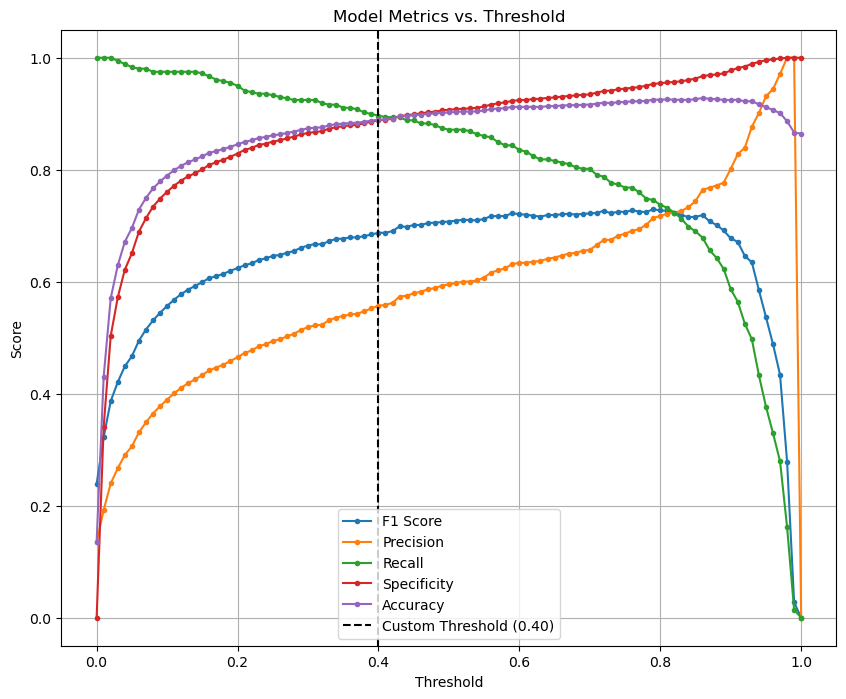


🔹 Classification report at custom threshold (0.40):
              precision    recall  f1-score   support

 Not at risk       0.98      0.89      0.93      2285
     At risk       0.56      0.90      0.69       358

    accuracy                           0.89      2643
   macro avg       0.77      0.89      0.81      2643
weighted avg       0.92      0.89      0.90      2643

🔹 Balanced Accuracy at threshold 0.40: 0.8925


In [180]:
# Custom setting threshold and get the best threshold for highest Recall
best_threshold, metrics_at_custom_threshold = tune_classification_threshold(best_model, X_test, y_test, set_threshold=0.40)


ROC AUC: 0.96


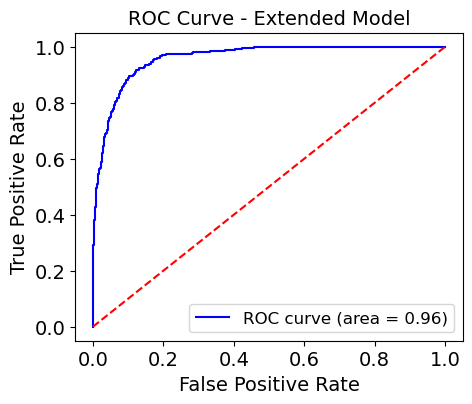

In [181]:
# Calculate ROC AUC score

#  "at risk" is class 1
double_risk_label = 1
# Get probabilities for each class
probs = best_model.predict_proba(X_test)

roc_auc = roc_auc_score(y_test, probs[:, double_risk_label])
print(f"ROC AUC: {roc_auc:.2f}")

# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test, probs[:, double_risk_label])

# Plot ROC curve
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')

# Adjust font sizes
plt.xlabel("False Positive Rate", fontsize=14)  
plt.ylabel("True Positive Rate", fontsize=14)  
plt.title("ROC Curve - Extended Model", fontsize=14)  
plt.legend(fontsize=12)  
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.savefig('./plots_of_results/roc_curve_extended_model.png', dpi=300, bbox_inches='tight')
plt.show()

# Experiment (use only income and SAP)

In [182]:
# select inputs and target variable for COM-3, use only train set for model selection
df_res = Train_x[['HYEARGRx','sap12']].copy()
y_res = Train_y.copy()

# compare model selection results, get the best selected model (xgb), sgb_preprocessor and scale_pos_weight
df_scores, select_model,preprocessor_xgb,scale_pos_weight = select_models(df_res, y_res)
df_scores

Time elapsed: 2.18 s


,Accuracy,Balanced accuracy
Random forest with undersampling,0.658217,0.670012
Random forest with balanced class weights,0.658217,0.670012
XGBoost with undersampling,0.652920,0.668894
XGBoost with scale_pos_weight,0.687978,0.675452


In [183]:
# copy data, make sure that train set is the same to data used for model selection, and test set is the one we separated at the beginning
X_train = df_res.copy()
y_train = y_res.copy()

X_test = Test_x[['HYEARGRx','sap12']].copy()
y_test = Test_y.copy()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7929, 2), (2643, 2), (7929,), (2643,))

In [184]:
# Train the model by X_train and y_train, and optimize XGBoost model by tunning hyperparameters, get the best model
best_model, best_params = tune_xgboost(select_model,preprocessor_xgb, scale_pos_weight, X_train, y_train,)

# Best model performance
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))

Hyperparameter tuning with RandomizedSearchCV

Hyperparameter Tuning Complete
Best Hyperparameters: {'xgb__colsample_bytree': 0.8645035840204937, 'xgb__gamma': 3.8563517334297286, 'xgb__learning_rate': 0.03221339552022711, 'xgb__max_depth': 9, 'xgb__n_estimators': 140, 'xgb__reg_alpha': 9.149596755437807, 'xgb__reg_lambda': 8.500385777897993, 'xgb__subsample': 0.7247253370691017}
Best Balanced Accuracy: 0.6986
              precision    recall  f1-score   support

           0       0.95      0.60      0.74      2285
           1       0.24      0.80      0.37       358

    accuracy                           0.63      2643
   macro avg       0.59      0.70      0.55      2643
weighted avg       0.85      0.63      0.69      2643

Balanced Accuracy: 0.6980446927374302


Tuning classification threshold

🔹 Best threshold for highest F1-score: 0.58


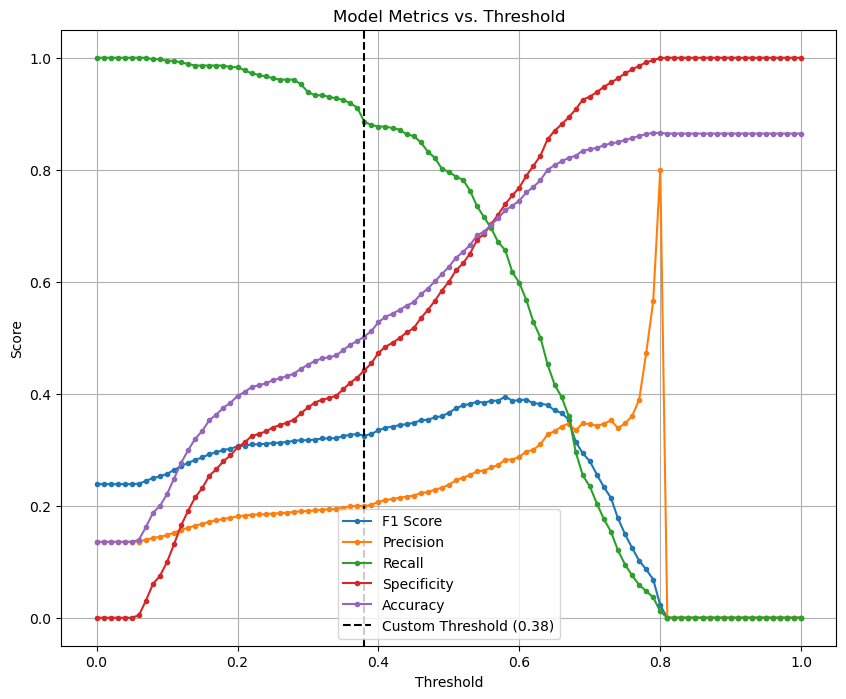


🔹 Classification report at custom threshold (0.38):
              precision    recall  f1-score   support

 Not at risk       0.96      0.44      0.61      2285
     At risk       0.20      0.89      0.33       358

    accuracy                           0.50      2643
   macro avg       0.58      0.66      0.47      2643
weighted avg       0.86      0.50      0.57      2643

🔹 Balanced Accuracy at threshold 0.38: 0.6637


In [185]:
# Custom setting threshold and get the best threshold for highest Recall
best_threshold, metrics_at_custom_threshold = tune_classification_threshold(best_model, X_test, y_test, set_threshold=0.38)

ROC AUC: 0.77


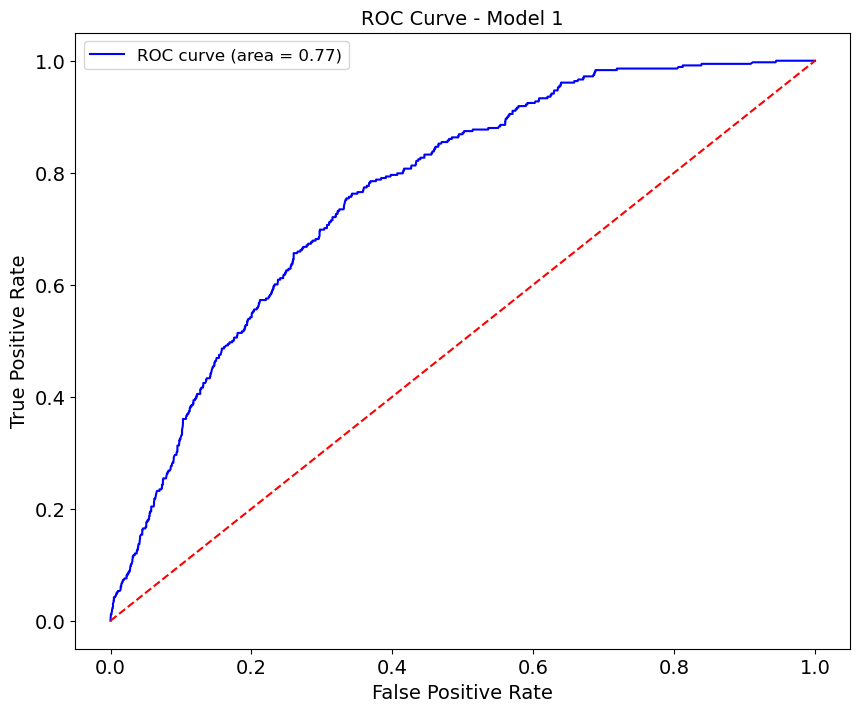

In [186]:
# Calculate ROC AUC score

#  "at risk" is class 1
double_risk_label = 1
# Get probabilities for each class
probs = best_model.predict_proba(X_test)

roc_auc = roc_auc_score(y_test, probs[:, double_risk_label])
print(f"ROC AUC: {roc_auc:.2f}")

# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test, probs[:, double_risk_label])

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')

# Adjust font sizes
plt.xlabel("False Positive Rate", fontsize=14)  
plt.ylabel("True Positive Rate", fontsize=14)  
plt.title("ROC Curve - Model 1", fontsize=14)  
plt.legend(fontsize=12)  
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.savefig('./plots_of_results/roc_curve_experiment.png', dpi=300, bbox_inches='tight')
plt.show()

# Orgnise result plot

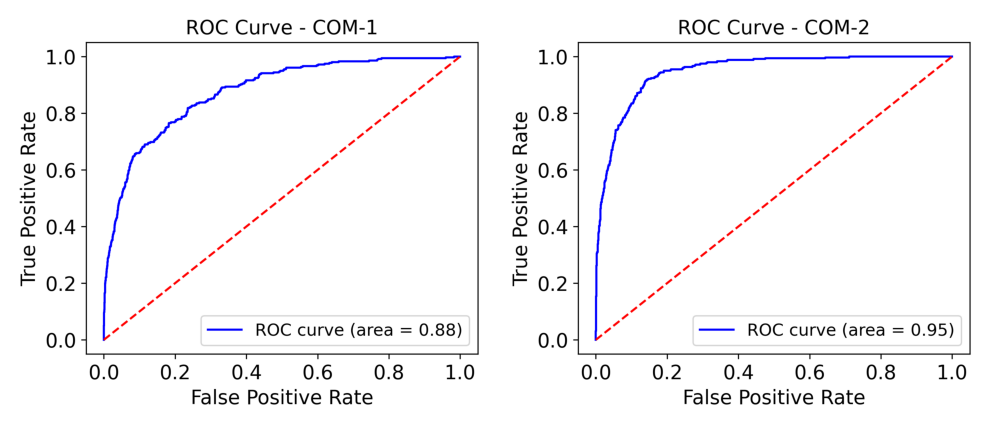

In [187]:
# organize the results plot in one figure, for roc_curve_com_1, roc_curve_com_2, roc_curve_com_3
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# ROC curve for COM-1
path = './plots_of_results/roc_curve_com_1.png'
img = plt.imread(path)
axs[0].imshow(img)
axs[0].axis('off')

# ROC curve for COM-2
path = './plots_of_results/roc_curve_com_2.png'
img = plt.imread(path)
axs[1].imshow(img)
axs[1].axis('off')

plt.tight_layout()
plt.savefig('./plots_of_results/roc_curve_comparisons.png', dpi=300, bbox_inches='tight')
plt.show()


# Plotting Performance metric result

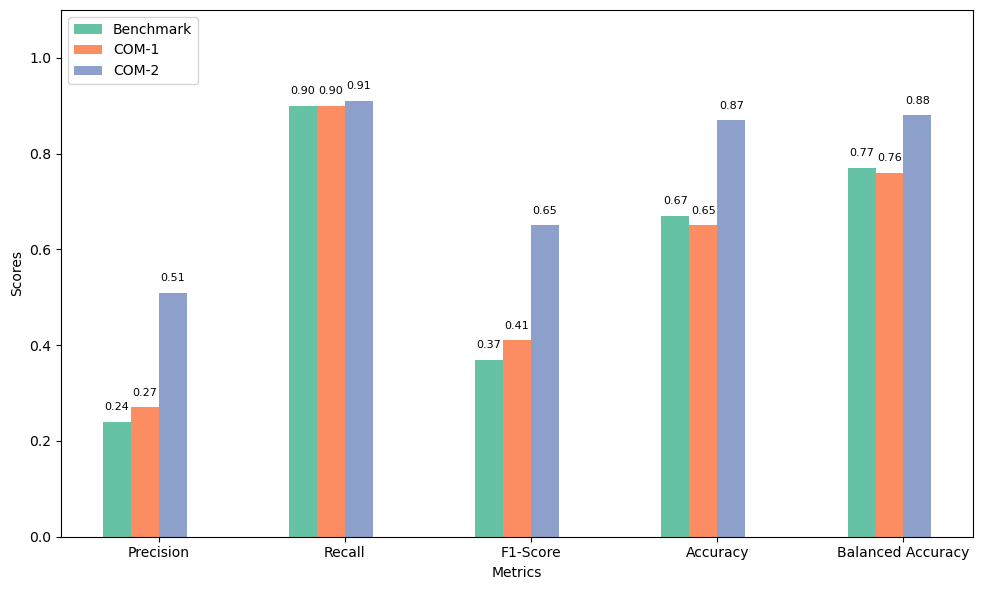

In [189]:
# plot performance metrics for all models
metric_results = pd.read_csv('performance_metric_result.csv')
metrics = ["Precision", "Recall", "F1-Score", "Accuracy", "Balanced Accuracy"]
bar_width = 0.15
index = np.arange(len(metrics))

# Extract performance scores
benchmark = metric_results.loc[0, metrics].values
com1 = metric_results.loc[1, metrics].values
com2 = metric_results.loc[2, metrics].values

# Define colors
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"] 
# Use Seaborn Set2 colors
set2_colors = sns.color_palette("Set2", 34)  # Extract 4 colors for the models

# Creating the bar plot
plt.figure(figsize=(10, 6))
bars = []

# Plot bars and store bar containers
bars.append(plt.bar(index, benchmark, bar_width, label="Benchmark", color=set2_colors[0], alpha=1))
bars.append(plt.bar(index + bar_width, com1, bar_width, label="COM-1", color=set2_colors[1], alpha=1))
bars.append(plt.bar(index + 2 * bar_width, com2, bar_width, label="COM-2", color=set2_colors[2], alpha=1))

# Adding value labels on top of each bar
for bar_group in bars:
    for bar in bar_group:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.2f}",
                 ha='center', va='bottom', fontsize=8, color='black', rotation=0)

# Formatting the plot
plt.xlabel("Metrics")
plt.ylabel("Scores")
# plt.title("Performance Comparison Across Models")
plt.xticks(index + 1.5 * bar_width, metrics)
plt.legend(loc="upper left")
plt.ylim(0, 1.1)  # Adjust ylim to make space for labels

plt.tight_layout()
plt.savefig('./plots_of_results/model_performance_metrics_labeled.png', dpi=300, bbox_inches='tight')
plt.show()
